In [ ]:
앙상블 학습 = 진단 학습
 - 학습기의 성능은 미학습 데이터에 대한 예측능력(일반능력)으로 평가
    
 - 일반화 능력을 향상시키는 방법은 단일 학습기의 성능을 향상 시킨다.

 - 개별적인 여러 각각의 학습 모델을 융합시켜서 향상 시킨다.
    
 - 데이터의 복잡도 강할 때, 순차적인 데이터

 - 같은 모델 학습기에서 학습한 결과를 취하는 모델
    
 - 다른 학습기에서 학습한 결과를 취하는 모델

 - 배깅, 랜덤 포레스트, 부스팅 사용(관점)
    
 - 랜덤 포레스트의 특징 : 일반화 오차 분해 된다.
    - 일반화 오차 = 바이어스(모델의 표현) + 바리안스(데이터셋) + 노이즈(본질적으로 줄일 수 없는 오류)

 - 결정트리 알고리즘 학습데이터로 부터 데이터 셋의 영향을 많이 받는 모델로 정확도를 판단하려면 데이터셋의 바리안스를 감소시킨다.

 - 학습데이터에서 n개의 데이터를 무작위로 복원추출 -> 표본 -> 결정트리(1단계) 
    -> 각 노드들은 d개의 특징량을 랜덤으로 비복원 추출(2단계)
    -> k번 반복 시킨다.(3단계)
    -> 의사결정 트리 당 예측률을 정리해서 다수값에 따라 클러스터 레이블을 할당한다.(4단계)
    
 - sklearn.tree.DecisionTreeClassifier : 단일 모델에서 entropy 지표를 지정하고 결정트리를 구성한다.

In [1]:
import  numpy  as  np
import  pandas  as  pd
from  sklearn  import  datasets
from  sklearn  import metrics
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import *
from  sklearn.model_selection  import  *
from sklearn.metrics import *
from  sklearn.ensemble   import *
# ex1) 랜덤 포레스트로 타이타닉 데이터를 모델링하자

## 1단계 csv ---> 데이터 프레임으로 변환
df = sns.load_dataset('titanic')

# 2단계 결측치 확인하고 제거하거나 치환한다.
# 2.1 타이타닉 데이터 프레임의 자료형을 확인한다. _파생변수
mask4 = (df.age<10) | (df.sex=='female')
df['child_women']=mask4.astype(int)

# 2.2 결측치(NaN) 을 확인한다.
# 2.3 deck 컬럼과 embark_town 컬럼을 삭제한다.
rdf = df.drop(['deck','embark_town'], axis =1)

# 2.4 age(나이) 열에 나이가 없는 모든행을 삭제한다.
# 데이터가 한개라도 없으면 drop 해라 (how = 'any')
# 모든 데이터가 없으면 drop 해라 (how = 'all')
rdf = rdf.dropna( subset=['age'], how='any', axis=0)

# 2.5 embark 열의 NaN 값을 승선도시중 가장 많이 출현한 값으로 치환하기
most_freq = rdf['embarked'].value_counts().idxmax()
rdf['embarked'].fillna(most_freq, inplace = True)

# 3단계 범주형 데이터를 숫자형으로 변환하기
# 3.1 feature selection (분석에 필요한 속성을 선택)
ndf = rdf[['survived','pclass','sex','age','sibsp','parch','embarked','child_women']]

# 선택된 컬럼중 2개(sex, embarked) 가 범주형이다.
#3.2 범주형 데이터를 숫자로 변환하기(원핫 인코딩)
gender = pd.get_dummies(ndf['sex'])
ndf = pd.concat([ndf,gender], axis= 1)
onehot_embarked = pd.get_dummies(ndf['embarked'])
ndf = pd.concat([ndf,onehot_embarked],axis=1)
ndf.drop(['sex','embarked'], axis=1, inplace = True)

# 4단계 정규화
# 4.1 독립변수와 종속변수(라벨) 을 지정한다.
# survived  pclass   age  sibsp  parch  female  male  C  Q  S
x = ndf[ ['pclass', 'age' ,'sibsp', 'parch' ,'female' ,'male', 'C' ,'Q' ,'S',
          'child_women'] ]
y = ndf['survived'] # 종속변수

# 4.2 독립변수들을 정규화 한다.
X = preprocessing.StandardScaler().fit(x).transform(x)

# 5단계 훈련 데이터를 훈련 데이터 / 테스트 데이터로 나눈다
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,
                                                 random_state = 33)

# sklearn 라이브러리에서 나이브베이즈 분류 모형 가져오기
tree_model = RandomForestClassifier( n_estimators=100,  oob_score=True,  random_state= 0 )
tree_model.fit( X_train, y_train )
print ( tree_model.oob_score_)

# 7단계 테스트 데이터로 예측을 한다.
y_hat = tree_model.predict( X_test )

# 8단계 모형의 예측능력을 평가한다.
randomforest_matrix = metrics.confusion_matrix( y_test, y_hat )
print( randomforest_matrix )
tn, fp, fn, tp = metrics.confusion_matrix( y_test, y_hat ).ravel()
f1_report = metrics.classification_report( y_test, y_hat )
print( f1_report )
#print(np.array([[tp,fp],[fn,tn]]))
accuracy = accuracy_score( y_test, y_hat)
print(accuracy)

0.7655310621242485
[[101  25]
 [ 17  72]]
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       126
           1       0.74      0.81      0.77        89

    accuracy                           0.80       215
   macro avg       0.80      0.81      0.80       215
weighted avg       0.81      0.80      0.81       215

0.8046511627906977


0.9777777777777777


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


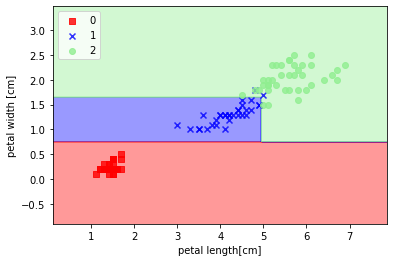

In [22]:
# ex02) sklearn.tree.DecisionTreeClassifier 사용해서 지표를 지정하고 결정 트리를 만들어보자
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# ==========================================================

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    #setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                            np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    X_test, y_test = X[test_idx, :], y[test_idx]
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='',
            alpha=1.0, linewidth=1, marker='o',
            s=55, label='test set')
        
# ==========================================================

# 1. 데이터 로드 iris()
iris = load_iris()

# 2. 데이터 설명 변수 지정
X = iris.data[:, [2,3]]

# 3. 목적 변수
y = iris.target

# 4. 데이터 분할 test_size=0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 5. 모델 지정
model = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

# 6. 학습
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# 7. 시각화
plot_decision_regions(X_train, y_train, classifier=model)
plt.xlabel('petal length[cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.show()

0.9333333333333333


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


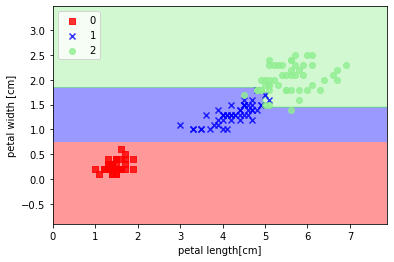

In [18]:
# ex02) sklearn.tree.DecisionTreeClassifier 사용해서 지표를 지정하고 결정 트리를 만들어보자
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# ==========================================================

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    #setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                            np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    X_test, y_test = X[test_idx, :], y[test_idx]
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='',
            alpha=1.0, linewidth=1, marker='o',
            s=55, label='test set')
        
# ==========================================================

# 1. 데이터 로드 iris()
iris = load_iris()

# 2. 데이터 설명 변수 지정
X = iris.data[:, [2,3]]

# 3. 목적 변수
y = iris.target

# 4. 데이터 분할 test_size=0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 5. 모델 지정  
# n_jobs = 2 -> cpu 코어 2개로 병렬 작업 하겠다.
# n_estimators = 10 -> 10개의 결정트리에서 랜덤 포레스트로 훈현하겠다.
model = RandomForestClassifier(criterion='entropy', n_estimators = 10, random_state=0, n_jobs=2)

# 6. 학습
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# 7. 시각화
x_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(x_combined, y_combined, classifier=model)
plt.xlabel('petal length[cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# !pip install xgboost
# https://github.com/dmlc/xgboost 

In [24]:
import xgboost as xgb   # tree의 기울기 증폭에 대한 고성능 분류 및 예측 모델

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   15.5s finished


{'max_depth': 6, 'n_estimators': 100} 0.6798701260430563
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
0.0002595104864831457
18.70080500081354


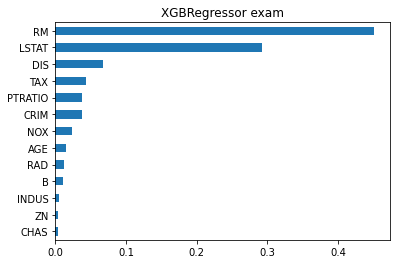

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error

boston = load_boston()
X_train, X_test = boston.data[:400], boston.data[400:]
y_train, y_test = boston.target[:400], boston.target[400:]

reg = xgb.XGBRegressor()
reg_cv = GridSearchCV(reg, {'max_depth': [2,4,6], 'n_estimators': [50,100,200]}, verbose=1)
reg_cv.fit(X_train, y_train)
print( reg_cv.best_params_, reg_cv.best_score_)
reg = xgb.XGBRegressor(**reg_cv.best_params_)
reg.fit(X_train, y_train)

print(reg)
pred_train = reg.predict(X_train)
pred_test = reg.predict(X_test)
print(mean_squared_error(y_train, pred_train))
print(mean_squared_error(y_test, pred_test))

img = pd.Series(reg.feature_importances_, index=boston.feature_names)
img = img.sort_values()
img.plot(kind='barh')
plt.title('XGBRegressor exam')
plt.show()

In [ ]:
# !pip install mlxtend

In [ ]:
mlxtend : 머신러닝, 데이터 분석 등의 작업에 유요한 정보를 클래스 또는 메소드로 제공하는 라이브러리
pipeline을 만들고 그리드 검색하고 처리하는데 사용하는 기능을 가진다.
plot_decision_regions를 사용하면 데이터의 분류 경계를 그려낸다.

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:57:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<AxesSubplot:>

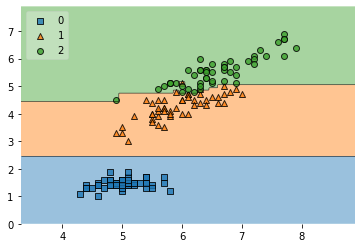

In [34]:
from mlxtend.plotting import plot_decision_regions
import xgboost as xgb
from xgboost import *

iris = load_iris()

X,y = iris.data[:,[0,2]], iris.target

result = XGBClassifier().fit(X,y)

plot_decision_regions(X, y, clf=result, res=0.02, legend=2)


In [30]:
#연관 규칙 : 특정 데이터가 있을 때, 다른 데이터도 존재하는 확률을 알아보기
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

dataset=[['사과','치즈','생수'],
['생수','호두','치즈','고등어'],
['수박','사과','생수'],
['생수','호두','치즈','옥수수']]

te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_) #위에서 나온걸 보기 좋게 데이터프레임으로 변경

frequent_itemsets = apriori(df, min_support=0.5, use_colnames=True)
print(frequent_itemsets )
print( association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3) )

   support      itemsets
0     0.50          (사과)
1     1.00          (생수)
2     0.75          (치즈)
3     0.50          (호두)
4     0.50      (생수, 사과)
5     0.75      (생수, 치즈)
6     0.50      (생수, 호두)
7     0.50      (호두, 치즈)
8     0.50  (생수, 호두, 치즈)
   antecedents consequents  antecedent support  consequent support  support  \
0         (생수)        (사과)                1.00                0.50     0.50   
1         (사과)        (생수)                0.50                1.00     0.50   
2         (생수)        (치즈)                1.00                0.75     0.75   
3         (치즈)        (생수)                0.75                1.00     0.75   
4         (생수)        (호두)                1.00                0.50     0.50   
5         (호두)        (생수)                0.50                1.00     0.50   
6         (호두)        (치즈)                0.50                0.75     0.50   
7         (치즈)        (호두)                0.75                0.50     0.50   
8     (생수, 호두)        (치즈)             

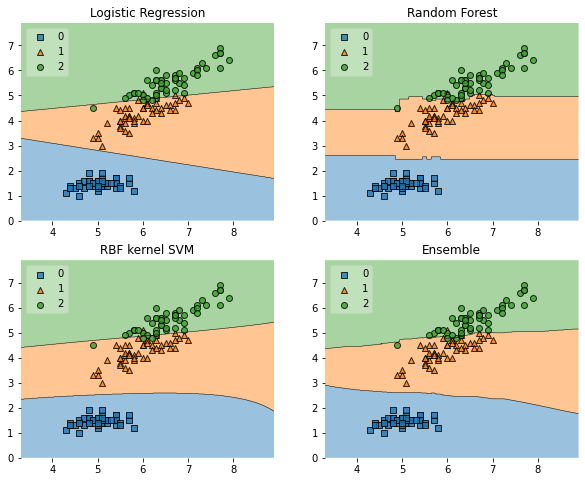

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.data import iris_data
from mlxtend.plotting import plot_decision_regions

# Initializing Classifiers
clf1 = LogisticRegression(random_state=0)
clf2 = RandomForestClassifier(random_state=0)
clf3 = SVC(random_state=0, probability=True)
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3], weights=[2, 1, 1], voting='soft')

# Loading some example data
X, y = iris_data()
X = X[:,[0, 2]]

# Plotting Decision Regions
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10, 8))

for clf, lab, grd in zip([clf1, clf2, clf3, eclf],
                         ['Logistic Regression', 'Random Forest', 'RBF kernel SVM', 'Ensemble'],
                         itertools.product([0, 1], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(lab)
plt.show()

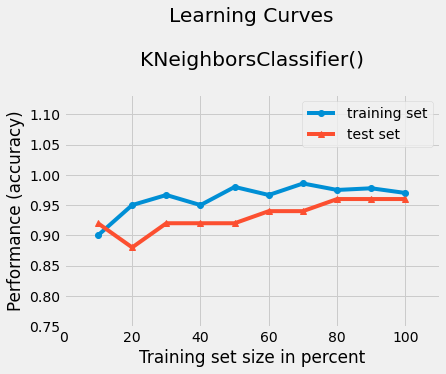

In [36]:
from mlxtend.plotting import plot_learning_curves
import matplotlib.pyplot as plt
from mlxtend.data import iris_data
from mlxtend.preprocessing import shuffle_arrays_unison
from sklearn.neighbors import KNeighborsClassifier
import numpy as np


# Loading some example data
X, y = iris_data()
X, y = shuffle_arrays_unison(arrays=[X, y], random_seed=123)
X_train, X_test = X[:100], X[100:]
y_train, y_test = y[:100], y[100:]

clf = KNeighborsClassifier(n_neighbors=5)

# 세로축, 적합율, 회수율, AUC, MSE
plot_learning_curves(X_train, y_train, X_test, y_test, clf, scoring='accuracy')
plt.show()

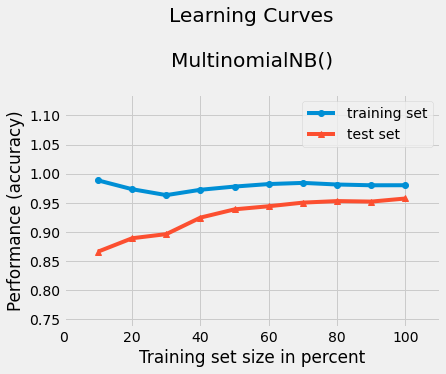

In [40]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']

newsgroups = fetch_20newsgroups(categories=categories, subset='all', shuffle=True, random_state=0)
tfidf = TfidfVectorizer(min_df=5, max_df=0.5)

X,y = tfidf.fit_transform(newsgroups.data), newsgroups.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)
clf = MultinomialNB()

plot_learning_curves(X_train, y_train, X_test, y_test, clf, scoring='accuracy')
plt.show()

In [ ]:
# !pip install lightgbm

In [43]:
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB 
from lightgbm import LGBMClassifier
from mlxtend.classifier import StackingClassifier  # 분류기에서 메타 분리기
from sklearn.datasets import fetch_20newsgroups
import numpy as np

categories = ['alt.atheism', 'soc.religion.christian',
              'comp.graphics', 'sci.med']
twenty_news = fetch_20newsgroups(subset='train',
    categories=categories, shuffle=True, random_state=42)
tfidf = TfidfVectorizer(min_df=5, max_df=0.5)
X, y = tfidf.fit_transform(twenty_news.data), twenty_news.target
clfs = [LGBMClassifier(random_state=1),
        LogisticRegression(),
        MultinomialNB(alpha=0.5),]

lr = LogisticRegression()
sclf = StackingClassifier(classifiers=clfs, 
                          use_probas=True,   # 예측확률 SVC / False = 값 전달
                          average_probas=False,   # True 예측 확률 평균 / False 확률의 벡터 결합
                          meta_classifier=lr)
print('3-fold cross validation:\n')

for clf, label in zip(clfs + [sclf], 
                      ['LightGBM', 
                       'Logistic Regression', 
                       'Naive Bayes',
                       'StackingClassifier']):
    scores = model_selection.cross_val_score(clf, X, y, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.93 (+/- 0.00) [LightGBM]
Accuracy: 0.96 (+/- 0.00) [Logistic Regression]
Accuracy: 0.96 (+/- 0.00) [Naive Bayes]
Accuracy: 0.95 (+/- 0.00) [StackingClassifier]
